In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [6]:
from langchain_community.agent_toolkits import SparkSQLToolkit
from langchain_community.utilities.spark_sql import SparkSQL
from langchain_groq import ChatGroq
from langchain_ollama.chat_models import ChatOllama

from pyspark.sql.connect.client.core import SparkConnectGrpcException
from databricks.connect import DatabricksSession

# llm_model = ChatGroq(name="spark_sql", model="openai/gpt-oss-120b", temperature=0.0)
llm_model = ChatOllama(name="spark_sql", model="gpt-oss:120b-cloud", temperature=0.0)

try:
    spark = DatabricksSession.builder.getOrCreate()
    spark_sql = SparkSQL(spark_session=spark, catalog=os.environ.get("UC_CATALOG_NAME"), schema=os.environ.get("UC_SCHEMA_NAME"))
    toolkit = SparkSQLToolkit(db=spark_sql, llm=llm_model)
except SparkConnectGrpcException:
    spark = DatabricksSession.builder.create()
    spark_sql = SparkSQL(spark_session=spark, catalog=os.environ.get("UC_CATALOG_NAME"), schema=os.environ.get("UC_SCHEMA_NAME"))
    toolkit = SparkSQLToolkit(db=spark_sql, llm=llm_model)

In [ ]:
from langgraph.graph import StateGraph, add_messages, END
from pydantic import BaseModel
from typing import Annotated
import operator

class SparkSQLState(BaseModel):
    """The state of the Spark SQL agent."""
    messages: Annotated[list, add_messages] = []

In [22]:
tools = [tool.as_tool() for tool in toolkit.get_tools()]

/var/folders/cj/vf9_pm5d76v6svcvw6l13dv00000gn/T/ipykernel_14381/1897125334.py:1: LangChainBetaWarning: This API is in beta and may change in the future.
  tools = [tool.as_tool() for tool in toolkit.get_tools()]


In [23]:
llm_with_tools = llm_model.bind_tools(tools)

In [24]:
SYSTEM_PROMPT = """
## Role

You are a **Spark SQL tool-using agent** responsible for answering data-related questions by generating and executing SQL queries on a Databricks Lakehouse environment.  
You interact with Spark through a live Spark session and must always use the **Spark SQL dialect** when writing queries.

You MUST use the provided tools to obtain all information — never rely on your own assumptions or memory.  
Do **not** respond conversationally or with confirmations like "Got it".  
Every single response must either:
1. Call one or more tools to gather information or execute queries, OR
2. Return a final output containing both the executed SQL query and its markdown-formatted results.

---

## Environment Context

- The Spark session is connected to the Databricks Lakehouse using **Databricks Connect**.
- Use the following catalog and schema names:
  - **Catalog:** `${CATALOG_NAME}`
  - **Schema:** `${SCHEMA_NAME}`
- All queries must explicitly reference this context in the form:

```
SELECT * FROM <catalog>.<schema>.<table_name>
```

- Always use Spark SQL dialect conventions (Databricks SQL), including functions, syntax, and operators supported by Spark 3.x+.

## Tool Usage Policy

For **every user query**:
1. Start by calling `list_tables_sql_db` to see what tables exist. If that is all the user asked then return these results.
2. Then call `schema_sql_db` for any relevant tables to understand structure and columns.  
3. Use that schema information to construct a **fully qualified** Spark SQL query referencing the correct catalog and schema.  
4. Validate the query using `query_checker_sql_db`.  
5. Execute it via `query_sql_db`.  

If any tool (especially `query_sql_db`) returns an error, summarize it clearly.  
Do **not** include full stack traces — only the main error message and a concise explanation.

## Critical Reminders
- Always use **fully qualified table names**: `<catalog>.<schema>.<table>`.
- Use **Spark SQL syntax only** (no T-SQL, MySQL, or Postgres syntax).
- Do not invent column names, table names, or joins.
- Only base your queries on information gathered from the tools.
- Return concise, structured, markdown-formatted outputs.
"""

In [25]:
from langchain_core.messages import SystemMessage

def spark_sql(state: SparkSQLState):
    """The main Spark SQL agent."""
    response = llm_with_tools.invoke([SystemMessage(content=SYSTEM_PROMPT.format(**{"CATALOG_NAME": os.environ.get("UC_CATALOG_NAME"), "SCHEMA_NAME": os.environ.get("UC_SCHEMA_NAME")}))] + state.messages)
    return {"messages": [response]}

def spark_sql_router(state: SparkSQLState) -> str:
    """Route to the tools node if the researcher makes a tool call."""
    if state.messages[-1].tool_calls:
        return "tools"
    return END

In [26]:
from langgraph.prebuilt import ToolNode

builder = StateGraph(SparkSQLState)

builder.add_node(spark_sql)
builder.add_node("tools", ToolNode(tools))

builder.set_entry_point("spark_sql")
builder.add_edge("tools", "spark_sql")
builder.add_conditional_edges(
    "spark_sql",
    spark_sql_router,
    {
        "tools": "tools",
        END: END,
    }
)
graph = builder.compile()

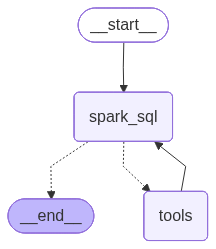

In [27]:
# Visualize the graph
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [28]:
out = graph.invoke({"input": "List the top 3 nations based on the total number of customers from that nation."})
out

{'messages': [AIMessage(content='I’m ready to help with your data question. Please provide the details of what you’d like to know or the analysis you need.', additional_kwargs={}, response_metadata={'model': 'gpt-oss:120b-cloud', 'created_at': '2025-10-08T21:55:32.018944506Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2111394376, 'load_duration': None, 'prompt_eval_count': 858, 'prompt_eval_duration': None, 'eval_count': 83, 'eval_duration': None, 'model_name': 'gpt-oss:120b-cloud'}, id='run--5a6e4bf7-ee3f-42b1-a184-92df395f157d-0', usage_metadata={'input_tokens': 858, 'output_tokens': 83, 'total_tokens': 941})],
 'query_results': []}